In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [210]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_score
from sklearn.metrics.pairwise import cosine_distances
from numpy import dot
from numpy.linalg import norm
import torch
import transformers as ppb
import warnings
import random
import matplotlib.pyplot as plt
from os import walk
from itertools import permutations, combinations
import pickle
import time
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind, linregress
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE


warnings.filterwarnings('ignore')
%matplotlib inline

In [259]:
def data2df(PATH):
    lines = open(PATH, encoding='iso-8859-1').read().strip().split('\n')
    lines = [line.split("\t") for line in lines]
    lines = pd.DataFrame(lines)
    lines = lines[lines[1] != 'UNCONFIDENT_INTENT_FROM_SLAD']
    lines[1] = lines[1].apply(lambda x: int(x)-1)
    return lines

def df2embd(df):
    max_row = min(len(df[df[1]==1]),len(df[df[1]==0]),1000)
    batch_1 = pd.concat((df[df[1]==1].sample(n=max_row, random_state=1),df[df[1]==0].sample(n=max_row, random_state=1)))
    tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    features = last_hidden_states[0][:,0,:].numpy()
    labels = batch_1[1]
    return features, np.array(labels)

def cos_dist(A, B):
       return 1 - (dot(A, B)/(norm(A)*norm(B)))

def S2T(train_features, train_labels, test_features, test_labels):
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    return lr_clf.score(test_features, test_labels)


def S2ti(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def S2t1(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = [test_features[i] for i,x in targets[0]]
    y_test = [test_labels[i] for i,x in targets[0]]
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_pred), axis=0)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    output_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    St1_score = sum(output_score)/len(output_score)    
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, St1_score, distribution
    else:
        return original_score, St1_score
    


def si2ti(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))

    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

    
    
def si2ti_1by1(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    while len(target_distances)>0:
        X_test = [test_features[target_distances[0][0]]]
        y_test = [test_labels[target_distances[0][0]]]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
        target_distances = target_distances[1:]
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def all_combination_test(func,num_i, include_S2T = True, dist_eval = False):
    data_permu = list(permutations(all_data,2))
    S2T_scores = []
    func_scores = []
    dist_list = []
    for index,permu in enumerate(data_permu):
        try:
            if dist_eval:
                S2T_scr, func_scr, dist = func(permu[0][0], permu[0][1], permu[1][0], permu[1][1],num_i,dist_eval = dist_eval)
                dist_list.append(dist)
            else:
                S2T_scr, func_scr = func(permu[0][0], permu[0][1], permu[1][0], permu[1][1],num_i,dist_eval = dist_eval)
            S2T_scores.append(S2T_scr)
            func_scores.append(func_scr)
            print(index)
        except Exception as e:
            print('error:',permu[0][2],permu[1][2],e)
            S2T_scores.append(999)
            func_scores.append(999)
    
    iterative_scores = [func_scores[i] - S2T_scores[i] for i in range(len(func_scores))]
    
    if dist_eval:
        return iterative_scores,S2T_scores,func_scores, dist_list
    else:
        return iterative_scores,S2T_scores,func_scores
    

def st_tf_distance(domain1, domain2):
    S_T = [domain1[0][i] for i,val in enumerate(domain1[1]) if val == 1]
    S_F = [domain1[0][i] for i,val in enumerate(domain1[1]) if val == 0]
    T_T = [domain2[0][i] for i,val in enumerate(domain2[1]) if val == 1]
    T_F = [domain2[0][i] for i,val in enumerate(domain2[1]) if val == 0]
    S_T_center = np.mean(S_T,axis = 0)
    S_F_center = np.mean(S_F,axis = 0)
    T_T_center = np.mean(T_T,axis = 0)
    T_F_center = np.mean(T_F,axis = 0)
    combi_TF = list(combinations([(S_T_center,'S_T'),(S_F_center,'S_F'),(T_T_center,'T_T'),(T_F_center,'T_F')],2))
    combi_TF_dist = [(cos_dist(d1[0], d2[0]),d1[1], d2[1]) for d1,d2 in combi_TF]
    combi_TF_dist.append((cos_dist(np.mean(domain1[0],axis = 0), np.mean(domain2[0],axis = 0)),'S','T'))
    return combi_TF_dist


def S2ti_lastModel(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    
    output_score = [test_labels[i]==y_pred[i] for i in range(len(y_pred))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    

def si2ti_lastModel(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))

    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
    
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    
    output_score = [test_labels[i]==y_pred[i] for i in range(len(y_pred))]
    
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    
def S2ti_true(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score


def S2ti_false(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 0],axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def si2ti_lastModel_true(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))

    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
    
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    
    output_score = [test_labels[i]==y_pred[i] for i in range(len(y_pred))]
    
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
def si2ti_prob(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.1
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def si2ti_prob_2(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.2
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def si2ti_prob_3(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.3
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

    
def si2ti_prob_4(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.4
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    

    
    
def upperbound(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    X_test = test_features
    y_test = test_labels
    lr_clf = LogisticRegression()
    lr_clf.fit(X_test, y_test)
    y_pred = lr_clf.predict(X_test)
    
    output_score = [y_pred[i]==y_test[i] for i in range(len(y_pred))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score


def si2ti_prob_4_adj(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
  
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        return_target = [target[i] for i in not_keep_index]
        if len(return_target) == len(previous_r_target):
            break
        previous_r_target = return_target[:]
        target_distances = return_target + target_distances
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
def si2ti_prob_4_adj_lm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        return_target = [target[i] for i in not_keep_index]
        if len(return_target) == len(previous_r_target):
            break
        previous_r_target = return_target[:]
        target_distances = return_target + target_distances
    
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    output_score = [y_pred[i]==test_labels[i] for i in range(len(y_pred))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    
def si2T_prob_4_adj(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    source_distances = [cos_dist(target_center, x) for x in train_features]
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(test_labels)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(test_labels)]]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def si2T_prob_4_adj_rand(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    
def S2T_prob_4_adj(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def si2T_prob_4_adj_rev(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    source_distances = [cos_dist(target_center, x) for x in train_features]
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1])
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(test_labels)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(test_labels)]]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_prob_4_adj_cycle_dl(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = X_pseudo + X_test_keep
        y_pseudo = y_pseudo + y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = abs(y_train_prob - 0.5)
        y_train_prob = [(i,prob) for i,prob in enumerate(y_train_prob)]
        y_train_prob = sorted(y_train_prob, key=lambda x: x[1])
        train_not_keep_index = [i for i,val in y_train_prob[:len(keep_index)]]
        len_init_X = len(X_train)
        X_train = [X_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_prob_4_adj_cycle_dm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = X_pseudo + X_test_keep
        y_pseudo = y_pseudo + y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = abs(y_train_prob - 0.5)
        y_train_prob = [(i,prob) for i,prob in enumerate(y_train_prob)]
        y_train_prob = sorted(y_train_prob, key=lambda x: x[1],reverse = True)
        train_not_keep_index = [i for i,val in y_train_prob[:len(keep_index)]]
        len_init_X = len(X_train)
        X_train = [X_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_prob_4_adj_cycle_dms(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    X_train_source = train_features[:]
    y_train_source = train_labels[:]
    X_train_target = []
    y_train_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = X_pseudo + X_test_keep
        y_pseudo = y_pseudo + y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train_source)[:, 0]
        y_train_prob = abs(y_train_prob - 0.5)
        y_train_prob = [(i,prob) for i,prob in enumerate(y_train_prob)]
        y_train_prob = sorted(y_train_prob, key=lambda x: x[1],reverse = True)
        train_not_keep_index = [i for i,val in y_train_prob[:len(keep_index)]]
        len_init_X = len(X_train_source)
        X_train_source = [X_train_source[i] for i in range(len_init_X) if i not in train_not_keep_index]
        X_train_target = X_train_target + X_test_keep
        X_train = X_train_source + X_train_target
        y_train_source = [y_train_source[i] for i in range(len_init_X) if i not in train_not_keep_index]
        y_train_target = y_train_target + y_pred_keep
        y_train = y_train_source + y_train_target
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    

def S2T_p4_adj_blc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    #######################################
    ###########    Standard        ########
    #######################################
    top_n = num_i
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_Xblc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i*2
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_blcTm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 100
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    X_balance = train_features[:]
    y_balance = train_labels[:]
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_balance, y_balance)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
#         y_train_prob = sorted(y_train_prob, key=lambda x: x[1])
        n_pos = sum(y_train)
        n_neg = len(y_train) - sum(y_train)
        if n_pos < n_neg: # if positive dominates
            X_balance = np.concatenate((X_train, [X_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
            y_balance = np.concatenate((y_train, [y_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
        elif n_pos > n_neg:
            X_balance = np.concatenate((X_train,[X_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
            y_balance = np.concatenate((y_train,[y_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_blcTl(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 20
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    X_balance = train_features[:]
    y_balance = train_labels[:]
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_balance, y_balance)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1],reverse = True)
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1])
#         y_train_prob = sorted(y_train_prob, key=lambda x: x[1])
        n_pos = sum(y_train)
        n_neg = len(y_train) - sum(y_train)
        if n_pos < n_neg: # if positive dominates
            X_balance = np.concatenate((X_train, [X_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
            y_balance = np.concatenate((y_train, [y_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
        elif n_pos > n_neg:
            X_balance = np.concatenate((X_train,[X_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
            y_balance = np.concatenate((y_train,[y_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def S2T_p4_adj_blc_dm_pm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    target_pred_prob_store = []
    
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        
        target_pred = lr_clf.predict(test_features)
        target_prob = lr_clf.predict_proba(test_features)[:, 0]
        target_prob = abs(target_prob-0.5)
        target_pred_prob_store.append([(target_pred[i],target_prob[i]) for i in range(len(test_labels))])
        
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:len(y_prob_P)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:len(y_prob_N)]]
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    
    max_prob = target_pred_prob_store[0]
    for row in target_pred_prob_store:
        max_prob = [sorted([max_prob[i],row[i]], key=lambda x: x[1], reverse = True)[0] for i in range(len(test_labels))]
    max_pred = [val[0] for val in max_prob]
    output_score = [max_pred[i]==test_labels[i] for i in range(len(test_labels))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def S2T_p4_adj_blc_dm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:len(y_prob_P)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:len(y_prob_N)]]
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression(n_jobs = -1)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_blc_dl(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1],reverse = True)
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:len(y_prob_P)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1])
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:len(y_prob_N)]]
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression(n_jobs = -1)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score   

    
def S2T_p4_adj_blc_int(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    s_center_P = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    s_center_N = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 0],axis = 0)
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')
        
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        
        X_test_keep_P = [X_test[i] for i in y_prob_P]
        y_pred_keep_P = [y_pred[i] for i in y_prob_P]
        X_test_keep_N = [X_test[i] for i in y_prob_N]
        y_pred_keep_N = [y_pred[i] for i in y_prob_N]
        
        X_inter_P = [np.mean([s_center_P,val],axis = 0) for val in X_test_keep_P]
        X_inter_N = [np.mean([s_center_N,val],axis = 0) for val in X_test_keep_N]
        
        X_train = np.concatenate([x for x in [X_train, X_test_keep, X_inter_P, X_inter_N] if len(x) >0], axis=0)
        y_train = np.concatenate([x for x in [y_train, y_pred_keep,y_pred_keep_P,y_pred_keep_N] if len(x) >0], axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_adj_blc_int(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    s_center_P = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    s_center_N = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 0],axis = 0)
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')
        
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        
        X_test_keep_P = [X_test[i] for i in y_prob_P]
        y_pred_keep_P = [y_pred[i] for i in y_prob_P]
        X_test_keep_N = [X_test[i] for i in y_prob_N]
        y_pred_keep_N = [y_pred[i] for i in y_prob_N]
        
        X_inter_P = [np.mean([s_center_P,val],axis = 0) for val in X_test_keep_P]
        X_inter_N = [np.mean([s_center_N,val],axis = 0) for val in X_test_keep_N]
        
        X_train = np.concatenate([x for x in [X_train, X_inter_P, X_inter_N] if len(x) >0], axis=0)
        y_train = np.concatenate([x for x in [y_train, y_pred_keep_P,y_pred_keep_N] if len(x) >0], axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_al_p4_adj_blc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    difference = source_center - target_center
    test_features = [val+difference for val in test_features]
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_al_p4_adj_blc_dm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    difference = source_center - target_center
    test_features = [val+difference for val in test_features]
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:len(y_prob_P)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:len(y_prob_N)]]
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'accuracy',accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),
              'train_size',len(y_train))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression(n_jobs = -1)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_Xblc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i*2
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_Xblc_dm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i*2
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:int(len(keep_index)/2)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:int(len(keep_index)/2)]]
        
        
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(y_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression(n_jobs = -1)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_cutAndGo(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    p_threshold = 0.05
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        if (max([val[1] for val in y_prob_P]) < p_threshold) and (min([val[1] for val in y_prob_N])>(1-p_threshold)):
            keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
            not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
            if len(keep_index)+len(not_keep_index) != len(y_pred):
                raise ValueError('top_n error!')

            X_test_keep = [X_test[i] for i in keep_index]
            y_pred_keep = [y_pred[i] for i in keep_index]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
            y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i in keep_index]
            print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
            X_test = [X_test[i] for i in not_keep_index]
            y_test = [y_test[i] for i in not_keep_index]
            if X_test == previous_r_target:
                break
            previous_r_target = X_test[:]
        else:
            X_train = X_pseudo[:]
            y_train = y_pseudo[:]
            break
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score)
    
    if dist_eval:
        return lm_score, 0, distribution
    else:
        return lm_score, 0
    
def S2T_al_cutAndGo(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    p_threshold = 0.05
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    difference = source_center - target_center
    test_features = [val+difference for val in test_features]
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        if (max([val[1] for val in y_prob_P]) < p_threshold) and (min([val[1] for val in y_prob_N])>(1-p_threshold)):
            keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
            not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
            if len(keep_index)+len(not_keep_index) != len(y_pred):
                raise ValueError('top_n error!')

            X_test_keep = [X_test[i] for i in keep_index]
            y_pred_keep = [y_pred[i] for i in keep_index]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
            y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i in keep_index]
            print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
            X_test = [X_test[i] for i in not_keep_index]
            y_test = [y_test[i] for i in not_keep_index]
            if X_test == previous_r_target:
                break
            previous_r_target = X_test[:]
        else:
            X_train = X_pseudo[:]
            y_train = y_pseudo[:]
            break
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score)
    
    if dist_eval:
        return lm_score, 0, distribution
    else:
        return lm_score, 0
    
    
def S2T_p4_adj_blc_tSNE(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    fig_list = []
    
    s_P = [val for i,val in enumerate(train_features) if train_labels[i] == 1]
    s_N = [val for i,val in enumerate(train_features) if train_labels[i] == 0]
    s_P_c = np.mean(s_P,axis = 0)
    s_N_c = np.mean(s_N,axis = 0)
    s_c = np.mean(s_P + s_N,axis = 0)
    t_P = [val for i,val in enumerate(X_test) if y_test[i] == 1]
    t_N = [val for i,val in enumerate(X_test) if y_test[i] == 0]
    t_P_c = np.mean(t_P,axis = 0)
    t_N_c = np.mean(t_N,axis = 0)
    t_c = np.mean(t_P + t_N,axis = 0)
    
    
    feature = s_P + s_N + t_P + t_N + [s_P_c,s_N_c,t_P_c,t_N_c,s_c,t_c]

    model = TSNE(learning_rate=200)
    transformed = model.fit_transform(feature)

    xs = transformed[:,0]
    ys = transformed[:,1]

    group = np.array([1]*len(s_P)+[2]*len(s_N)+[3]*len(t_P)+[4]*len(t_N)+[5,6,7,8,9,10])
    cdict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5:'orange', 6:'purple', 7:'black', 8:'cyan',9:'green',10:'red'}

    fig, ax = plt.subplots(figsize = [8,8])
    for g in np.unique(group):
        ix = np.where(group == g)
        if g >=5:
            ax.scatter(xs[ix], ys[ix], c = cdict[g], label = g, s = 100)
        else:
            ax.scatter(xs[ix], ys[ix], c = cdict[g], label = g, s = 10)
    fig_list.append(fig)
        
        
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
        y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
        
        t_P = [val for i,val in enumerate(X_test) if y_test[i] == 1]
        t_N = [val for i,val in enumerate(X_test) if y_test[i] == 0]
        
        p_P = [val for i,val in enumerate(X_pseudo) if y_pseudo[i] == 1]
        p_N = [val for i,val in enumerate(X_pseudo) if y_pseudo[i] == 0]
        p_P_c = np.mean(p_P,axis = 0)
        p_N_c = np.mean(p_N,axis = 0)
        p_c = np.mean(p_P + p_N,axis = 0)
        
        feature = s_P + s_N + t_P + t_N + p_P + p_N + [
            s_P_c, s_N_c,
            t_P_c, t_N_c,
            p_P_c ,p_N_c,
            s_c, t_c, p_c]

        model = TSNE(learning_rate=200)
        transformed = model.fit_transform(feature)

        xs = transformed[:,0]
        ys = transformed[:,1]

        group = np.array([1]*len(s_P)+[2]*len(s_N)+[3]*len(t_P)+[4]*len(t_N)+[5]*len(p_P)+[6]*len(p_N)+[7,8,9,10,11,12,13,14,15])
        cdict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5:'pink', 6:'purple',
                 7:'black', 8:'purple', 
                 9:'black', 10:'cyan',
                 11:'brown',12:'magenta',
                 13:'green',14:'red',15:'olive'}

        fig, ax = plt.subplots(figsize = [8,8])
        for g in np.unique(group):
            ix = np.where(group == g)
            if g >=7:
                ax.scatter(xs[ix], ys[ix], c = cdict[g], label = g, s = 100)
            else:
                ax.scatter(xs[ix], ys[ix], c = cdict[g], label = g, s = 10)
        fig_list.append(fig)
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, fig_list, distribution
    else:
        return lm_score, fig_list
    
def S2T_al_mc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # moving center
    top_n = num_i
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    difference = source_center - target_center
    test_features = [val+difference for val in test_features]
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    
    
    s_P = [val for i,val in enumerate(X_train) if y_train[i] == 1]
    s_N = [val for i,val in enumerate(X_train) if y_train[i] == 0]
    s_P_c = np.mean(s_P,axis = 0)
    s_N_c = np.mean(s_N,axis = 0)
    s_c = np.mean(s_P + s_N,axis = 0)
    p_P_c = s_P_c[:]
    p_N_c = s_N_c[:]
    
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_pseudo_P = [(i,val,cos_dist(p_P_c,val)) for i,val in enumerate(X_test) if y_pred[i] == 0]
        X_pseudo_P = sorted(X_pseudo_P, key=lambda x: x[2])
        X_pseudo_P = X_pseudo_P[:top_n]
        X_pseudo_N = [(i,val,cos_dist(p_N_c,val)) for i,val in enumerate(X_test) if y_pred[i] == 1]
        X_pseudo_N = sorted(X_pseudo_N, key=lambda x: x[2])
        X_pseudo_N = X_pseudo_N[:top_n]

        keep_index = [val[0] for val in X_pseudo_P] + [val[0] for val in X_pseudo_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
        y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
        p_P_c =  np.mean([X_pseudo[i] for i,val in enumerate(y_pseudo) if val == 0],axis = 0)
        p_N_c =  np.mean([X_pseudo[i] for i,val in enumerate(y_pseudo) if val == 1],axis = 0)
        
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
              'true_true',sum([y_test[i] for i in keep_index])
             )
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)       
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p_align(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    difference = source_center - target_center
    test_features = [val+difference for val in test_features]
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    
    s_P = [val for i,val in enumerate(X_train) if y_train[i] == 1]
    s_N = [val for i,val in enumerate(X_train) if y_train[i] == 0]
    s_P_c = np.mean(s_P,axis = 0)
    s_N_c = np.mean(s_N,axis = 0)
    s_c = np.mean(s_P + s_N,axis = 0)
    
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
#         X_train = np.concatenate((X_train, X_test_keep), axis=0)
#         y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
        y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        try:
            print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
        except:
            pass
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        
        if len(X_test)>0:
            t_P = [val for i,val in enumerate(X_pseudo) if y_pseudo[i] == 1]
            t_N = [val for i,val in enumerate(X_pseudo) if y_pseudo[i] == 0]
            t_P_c = np.mean(t_P,axis = 0)
            t_N_c = np.mean(t_N,axis = 0)
            t_c = np.mean(np.concatenate([data for data in [t_P, t_N] if len(data)>0], axis=0),axis = 0)
            reg = LinearRegression().fit([t_P_c,t_N_c], [s_P_c,s_N_c])
            X_test = reg.predict(X_test)
            X_pseudo = reg.predict(X_pseudo)
        
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def S2T_al_mc_align(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # moving center
    top_n = num_i
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    difference = source_center - target_center
    test_features = [val+difference for val in test_features]
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    
    
    s_P = [val for i,val in enumerate(X_train) if y_train[i] == 1]
    s_N = [val for i,val in enumerate(X_train) if y_train[i] == 0]
    s_P_c = np.mean(s_P,axis = 0)
    s_N_c = np.mean(s_N,axis = 0)
    s_c = np.mean(s_P + s_N,axis = 0)
    
#     lr_clf = LogisticRegression()
#     lr_clf.fit(X_train, y_train)
#     y_pred = lr_clf.predict(X_test)
#     y_pred = lr_clf.predict(X_test)
#     y_prob = lr_clf.predict_proba(X_test)[:, 0]
#     y_prob = [(i,val) for i,val in enumerate(y_prob)]
#     y_prob_P = [val for val in y_prob if val[1]<0.5]
#     y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
#     x_prob_P = [X_test[i] for i,val in y_prob_P[:top_n]]
#     y_prob_N = [val for val in y_prob if val[1]>=0.5]
#     y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
#     x_prob_N = [X_test[i] for i,val in y_prob_N[:top_n]]
    
#     p_P_c =  np.mean(x_prob_P,axis = 0)
#     p_N_c =  np.mean(x_prob_N,axis = 0)
    
    p_P_c = s_P_c[:]
    p_N_c = s_N_c[:]
    
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_pseudo_P = [(i,val,cos_dist(p_P_c,val)) for i,val in enumerate(X_test) if y_pred[i] == 0]
        X_pseudo_P = sorted(X_pseudo_P, key=lambda x: x[2])
        X_pseudo_P = X_pseudo_P[:top_n]
        X_pseudo_N = [(i,val,cos_dist(p_N_c,val)) for i,val in enumerate(X_test) if y_pred[i] == 1]
        X_pseudo_N = sorted(X_pseudo_N, key=lambda x: x[2])
        X_pseudo_N = X_pseudo_N[:top_n]

        keep_index = [val[0] for val in X_pseudo_P] + [val[0] for val in X_pseudo_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
        y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
        p_P_c =  np.mean([X_pseudo[i] for i,val in enumerate(y_pseudo) if val == 0],axis = 0)
        p_N_c =  np.mean([X_pseudo[i] for i,val in enumerate(y_pseudo) if val == 1],axis = 0)
        
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
              'true_true',sum([y_test[i] for i in keep_index])
             )
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
         
        if len(X_test)>0:
            t_P = [val for i,val in enumerate(X_pseudo) if y_pseudo[i] == 1]
            t_N = [val for i,val in enumerate(X_pseudo) if y_pseudo[i] == 0]
            t_P_c = np.mean(t_P,axis = 0)
            t_N_c = np.mean(t_N,axis = 0)
            t_c = np.mean(np.concatenate([data for data in [t_P, t_N] if len(data)>0], axis=0),axis = 0)
            reg = LinearRegression().fit([t_P_c,t_N_c], [s_P_c,s_N_c])
            X_test = reg.predict(X_test)
            X_pseudo = reg.predict(X_pseudo)
            X_test_keep = reg.predict(X_test_keep)
#             X_train = np.concatenate((X_train, X_test_keep), axis=0)
#             y_train = np.concatenate((y_train, y_pred_keep), axis=0)

    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)       
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_hh(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    test_features = hh(train_features, train_labels, test_features, test_labels)
   
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    
    return original_score, lr_clf.score(test_features, test_labels)

def linear_trans(train_features, train_labels, test_features, test_labels):
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    s_P = [val for i,val in enumerate(train_features) if train_labels[i] == 1]
    s_N = [val for i,val in enumerate(train_features) if train_labels[i] == 0]
    s_P_c = np.mean(s_P,axis = 0)
    s_N_c = np.mean(s_N,axis = 0)
    s_c = np.mean(s_P + s_N,axis = 0)
    
    t_P = [val for i,val in enumerate(test_features) if test_labels[i] == 1]
    t_N = [val for i,val in enumerate(test_features) if test_labels[i] == 0]
    t_P_c = np.mean(t_P,axis = 0)
    t_N_c = np.mean(t_N,axis = 0)
    t_c = np.mean(t_P + t_N,axis = 0)
    
    v_s = s_P_c - s_N_c
    v_t = t_P_c - t_N_c
    
    reg = LinearRegression().fit([t_P_c,t_N_c], [s_P_c,s_N_c])
    test_features = reg.predict(test_features)
    return test_features

def S2T_p4_adj_blc_hh(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    
    test_features = linear_trans(train_features, train_labels, test_features, test_labels)
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        try:
            print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
        except:
            pass
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_al_mc_hh(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # moving center
    top_n = num_i
    
    test_features = hh(train_features, train_labels, test_features, test_labels)
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    
    
    s_P = [val for i,val in enumerate(X_train) if y_train[i] == 1]
    s_N = [val for i,val in enumerate(X_train) if y_train[i] == 0]
    s_P_c = np.mean(s_P,axis = 0)
    s_N_c = np.mean(s_N,axis = 0)
    s_c = np.mean(s_P + s_N,axis = 0)
    p_P = [val for i,val in enumerate(X_test) if y_test[i] == 1]
    p_N = [val for i,val in enumerate(X_test) if y_test[i] == 0]
    p_P_c = np.mean(p_P,axis = 0)
    p_N_c = np.mean(p_N,axis = 0)    
    
    
#     p_P_c = p_P_c[:]
#     p_N_c = s_N_c[:]
    
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_pseudo_P = [(i,val,cos_dist(p_P_c,val)) for i,val in enumerate(X_test) if y_pred[i] == 0]
        X_pseudo_P = sorted(X_pseudo_P, key=lambda x: x[2])
        X_pseudo_P = X_pseudo_P[:top_n]
        X_pseudo_N = [(i,val,cos_dist(p_N_c,val)) for i,val in enumerate(X_test) if y_pred[i] == 1]
        X_pseudo_N = sorted(X_pseudo_N, key=lambda x: x[2])
        X_pseudo_N = X_pseudo_N[:top_n]

        keep_index = [val[0] for val in X_pseudo_P] + [val[0] for val in X_pseudo_N]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
        y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
        p_P_c =  np.mean([X_pseudo[i] for i,val in enumerate(y_pseudo) if val == 0],axis = 0)
        p_N_c =  np.mean([X_pseudo[i] for i,val in enumerate(y_pseudo) if val == 1],axis = 0)
        
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
              'true_true',sum([y_test[i] for i in keep_index])
             )
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)       
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_hh_cutAndGo(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = num_i
    p_threshold = 0.10
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    test_features = hh(train_features, train_labels, test_features, test_labels)
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = y_prob_P[:top_n]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = y_prob_N[:top_n]
        if (max([val[1] for val in y_prob_P]) < p_threshold) and (min([val[1] for val in y_prob_N])>(1-p_threshold)):
            keep_index = [val[0] for val in y_prob_P] + [val[0] for val in y_prob_N]
            not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
            if len(keep_index)+len(not_keep_index) != len(y_pred):
                raise ValueError('top_n error!')

            X_test_keep = [X_test[i] for i in keep_index]
            y_pred_keep = [y_pred[i] for i in keep_index]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            X_pseudo = np.concatenate([data for data in [X_pseudo, X_test_keep] if len(data)>0], axis=0)
            y_pseudo = np.concatenate([data for data in [y_pseudo, y_pred_keep] if len(data)>0], axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i in keep_index]
            print('total:',len(y_pred_keep),'accuracy',round(accuracy_score(y_pred_keep,[y_test[i] for i in keep_index]),2),
                  'true_true',sum([y_test[i] for i in keep_index]),
                  'min_P',round(max([val[1] for val in y_prob_P]),2),
                  'min_N',round(min([val[1] for val in y_prob_N]),2),
                 )
            X_test = [X_test[i] for i in not_keep_index]
            y_test = [y_test[i] for i in not_keep_index]
            if X_test == previous_r_target:
                break
            previous_r_target = X_test[:]
        else:
            X_train = X_pseudo[:]
            y_train = y_pseudo[:]
            break
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score)
    
    if dist_eval:
        return lm_score, 0, distribution
    else:
        return lm_score, 0
    
def S2T_hh(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    sourcePos = [val for i,val in enumerate(train_features) if train_labels[i] == 1]
    sourceNeg = [val for i,val in enumerate(train_features) if train_labels[i] == 0]
    targetPos = [val for i,val in enumerate(test_features) if test_labels[i] == 1]
    targetNeg = [val for i,val in enumerate(test_features) if test_labels[i] == 0]
    v = np.mean(sourcePos, axis=0) - np.mean(sourceNeg, axis=0)
    u = np.mean(targetPos, axis=0) - np.mean(targetNeg, axis=0)
    c1 = np.mean(np.concatenate([targetPos, targetNeg], axis=0), axis=0)
    c2 = np.mean(np.concatenate([sourcePos, sourceNeg], axis=0), axis=0)

    test_features = hh(u, v, c1, c2, test_features)
   
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    
    return original_score, lr_clf.score(test_features, test_labels)

def S2T_p_hh(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    threshold = 0.05
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    y_pred = lr_clf.predict(test_features)
    y_prob = lr_clf.predict_proba(test_features)[:, 0]
    y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
    y_prob_P = [val for val in y_prob if val[1]<threshold]
    y_prob_N = [val for val in y_prob if val[1]>=(1-threshold)]
    
    
    sourcePos = [val for i,val in enumerate(train_features) if train_labels[i] == 1]
    sourceNeg = [val for i,val in enumerate(train_features) if train_labels[i] == 0]
    targetPos = [test_features[val[0]] for val in y_prob_P]
    targetNeg = [test_features[val[0]] for val in y_prob_N]
    v = np.mean(sourcePos, axis=0) - np.mean(sourceNeg, axis=0)
    u = np.mean(targetPos, axis=0) - np.mean(targetNeg, axis=0)
    c1 = np.mean(test_features, axis=0)
    c2 = np.mean(np.concatenate([sourcePos, sourceNeg], axis=0), axis=0)
    
    
    
    test_features = hh(u, v, c1, c2,test_features)
   
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    
    return original_score, lr_clf.score(test_features, test_labels)


def hh(u, v, c1, c2,points):
    u_mag = np.linalg.norm(u)
    u_unit = u / u_mag
    
    v_mag = np.linalg.norm(v)
    v_unit = v / v_mag

    #Scaling so pos-neg vectors have the same magnitude
    scaled_points = points * v_mag / u_mag
    scaled_c1 = c1 * v_mag / u_mag
    
    #gettinng dimension of vector space
    k = len(c2)

    #calculating isometric linear transformation: householder transformation
    A = np.eye(k) - (2 * (np.outer(u_unit-v_unit, u_unit-v_unit)\
                        /  np.inner(u_unit-v_unit, u_unit-v_unit)))

    #applying isometric transformation
    points_after_isometric = scaled_points @ A.T
    c1_after_isometric = scaled_c1 @ A.T

    #translation
    points_after_translation = points_after_isometric + (c2 - c1_after_isometric)

    return points_after_translation


def S2T_p_hh_selftrain(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    threshold = 0.05
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    y_pred = lr_clf.predict(test_features)
    y_prob = lr_clf.predict_proba(test_features)[:, 0]
    y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
    y_prob_P = [val for val in y_prob if val[1]<threshold]
    y_prob_N = [val for val in y_prob if val[1]>=(1-threshold)]
    
    
    sourcePos = [val for i,val in enumerate(train_features) if train_labels[i] == 1]
    sourceNeg = [val for i,val in enumerate(train_features) if train_labels[i] == 0]
    targetPos = [test_features[val[0]] for val in y_prob_P]
    targetNeg = [test_features[val[0]] for val in y_prob_N]
    v = np.mean(sourcePos, axis=0) - np.mean(sourceNeg, axis=0)
    u = np.mean(targetPos, axis=0) - np.mean(targetNeg, axis=0)
    c1 = np.mean(test_features, axis=0)
    c2 = np.mean(np.concatenate([sourcePos, sourceNeg], axis=0), axis=0)
    
    
    
    test_features = hh(u, v, c1, c2,test_features)
   
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    y_pred = lr_clf.predict(test_features)
    
    train_features = np.concatenate([train_features, test_features], axis=0)
    train_labels = np.concatenate([train_labels, y_pred], axis=0)
    
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    
    
    return original_score, lr_clf.score(test_features, test_labels)

def S2T_selftrain(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    original_score = S2T(train_features, train_labels, test_features, test_labels)
       
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    y_pred = lr_clf.predict(test_features)
    
    train_features = np.concatenate([train_features, test_features], axis=0)
    train_labels = np.concatenate([train_labels, y_pred], axis=0)
    
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    
    
    return original_score, lr_clf.score(test_features, test_labels)

In [4]:
# ## Save pickle
# with open("./data/amazon_review/data.pickle","wb") as fw:
#     pickle.dump(all_data, fw)

## Load pickle
with open("./data/amz_bekd_bert.pickle","rb") as fr:
    all_data = pickle.load(fr)
[val[2] for val in all_data]

['Books', 'Electronics', 'Home_and_Kitchen', 'Movies_and_TV']

In [275]:
upperbounds = []
for i in all_data:
    lr_clf = LogisticRegression()
    upperbounds.append(np.mean(cross_val_score(lr_clf,X = i[0], y = i[1], cv = 5)))

In [216]:
np.mean(upperbound)

0.9123749999999999

In [285]:
S2T_p_hh_selftrain_result = all_combination_test(S2T_p_hh_selftrain,100, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


In [288]:
S2T_selftrain_result = all_combination_test(S2T_selftrain,100, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


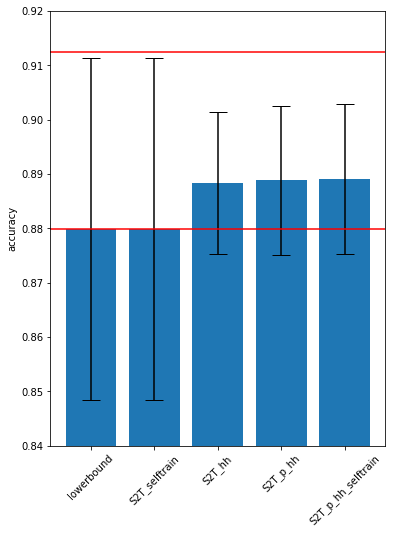

In [289]:
plot_data = [
            S2T_hh_result[1],
    S2T_selftrain_result[2],
    S2T_hh_scale_result[2],
    S2T_p_hh_scale_result[2],
    S2T_p_hh_selftrain_result[2]
#             upperbounds
    
            ]
labels = [ 'lowerbound', 
          'S2T_selftrain',
          'S2T_hh',
          'S2T_p_hh',
          'S2T_p_hh_selftrain'
#           'upperbound'
                     ]
plot_mean = [np.mean(val) for val in plot_data]
plot_stdev = [np.std(val) for val in plot_data]

plt.figure(figsize = [6,8])
plt.bar(labels,plot_mean,yerr=plot_stdev, capsize=9)
plt.ylabel('accuracy')
plt.xticks(rotation=45)
plt.ylim([0.84, 0.92])
plt.axhline(y = 0.9123749999999999,color = 'r') #np.mean(upperbounds[2])
plt.axhline(y = 0.8797916666666666,color = 'r')#np.mean(si2ti_prob_4_5[1])
plt.show()

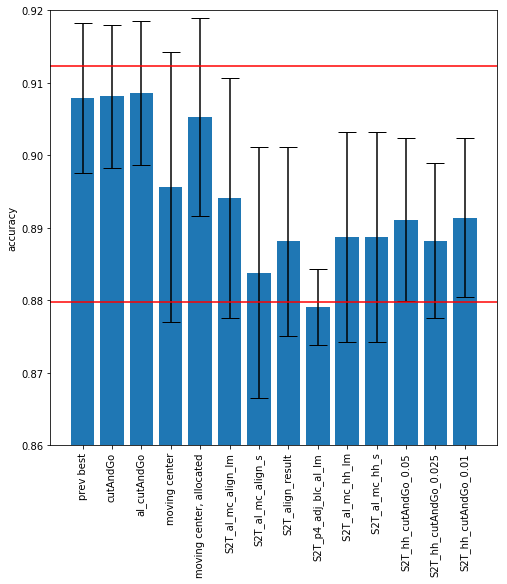

In [237]:
plot_data = [S2T_dist_blc[1],
             S2T_cutAndGo_result[1],
             S2T_al_cutAndGo_result[1],
             S2T_mc_result[1],
             S2T_al_mc_result[1],
             S2T_al_mc_align_result[1],
             S2T_al_mc_align_result[2],
             S2T_align_result[2],
             S2T_p4_adj_blc_al_result[1],
             S2T_al_mc_hh_result[1],
              S2T_al_mc_hh_result[2],
             S2T_al_cutAndGo_hh_result[1],
             S2T_hh_cutAndGo_result[1],
             S2T_hh_cutAndGo_result_001[1]
            ]
labels = [             'prev best', 
                      'cutAndGo',
          'al_cutAndGo',
          'moving center',
          'moving center, allocated',
          'S2T_al_mc_align_lm',
          'S2T_al_mc_align_s',
          'S2T_align_result',
          'S2T_p4_adj_blc_al_lm',
          ' S2T_al_mc_hh_lm',
          ' S2T_al_mc_hh_s',
          'S2T_hh_cutAndGo_0.05',
          'S2T_hh_cutAndGo_0.025',
          'S2T_hh_cutAndGo_0.01'
                     ]
plot_mean = [np.mean(val) for val in plot_data]
plot_stdev = [np.std(val) for val in plot_data]

plt.figure(figsize = [8,8])
plt.bar(labels,plot_mean,yerr=plot_stdev, capsize=9)
plt.ylabel('accuracy')
plt.xticks(rotation=90)
plt.ylim([0.86, 0.92])
plt.axhline(y = 0.9123749999999999,color = 'r') #np.mean(upperbounds[2])
plt.axhline(y = 0.8797916666666666,color = 'r')#np.mean(si2ti_prob_4_5[1])
plt.show()